In [ ]:
import os
from glob import glob
import random
from pathlib import Path
import pickle
from functools import partial
import numpy as np
import yaml

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme();
from IPython.display import clear_output
from celluloid import Camera

from sage.training.trainer import MRITrainer
from sage.visualization.vistool import plot_vismap
from sage.visualization.utils import check_type
from sage.config import load_config
from utils.analysis import (
    Result, FileSelector, 
    group_stats, cherry_picker, check_existence, save2nifti, MAE, transform
)

In [ ]:
AVG = np.load("./data/average.npy")
naive_sel = FileSelector("naive")
gt_result = np.array(naive_sel.test_gt)
epoch_parser = lambda path: int(path.split("/layer0/ep")[-1].split("_mae")[0])
mae_parser = lambda path: float(path.split("_mae")[-1].split(".npy")[0])

In [ ]:
with open("./data/naive_reg_test_100.pkl", "rb") as f:
    naive_results = pickle.load(f)
    naive_results = {e[0]: e[1] for e in sorted(naive_results.items(), key=lambda x: x[0])}
    
with open("./data/augment_reg_test_100.pkl", "rb") as f:
    augment_results = pickle.load(f)
    augment_results = {e[0]: e[1] for e in sorted(augment_results.items(), key=lambda x: x[0])}

In [ ]:
with open("./data/naive_nonreg_test_100.pkl", "rb") as f:
    naive_nonreg_results = pickle.load(f)
    naive_nonreg_results = {e[0]: e[1] for e in sorted(naive_nonreg_results.items(), key=lambda x: x[0])}
    
with open("./data/augment_nonreg_test_100.pkl", "rb") as f:
    augment_nonreg_results = pickle.load(f)
    augment_nonreg_results = {e[0]: e[1] for e in sorted(augment_nonreg_results.items(), key=lambda x: x[0])}

In [ ]:
naive = Result(naive_results)
augment = Result(augment_results)

naive_nonreg = Result(naive_nonreg_results)
augment_nonreg = Result(augment_nonreg_results)

In [ ]:
last_values_naive = [e[-1][1] for e in naive.raw_data.values()]
last_values_augment = [e[-1][1] for e in augment.raw_data.values()]

best_values_naive = [min(_[1] for _ in e) for e in naive.raw_data.values()]
best_values_augment = [min(_[1] for _ in e) for e in augment.raw_data.values()]

earlystopped_values_naive = [e[-20][1] for e in naive.raw_data.values()]
earlystopped_values_augment = [e[-20][1] for e in augment.raw_data.values()]

total_train_naive = [len(e) for e in naive.raw_data.values()]
total_train_augment = [len(e) for e in augment.raw_data.values()]

best_indices_naive = [sorted(e, key=lambda x: x[1])[0][0] for e in naive.raw_data.values()]
best_indices_augment = [sorted(e, key=lambda x: x[1])[0][0] for e in augment.raw_data.values()]

In [ ]:
last_values_naive_nonreg = [e[-1][1] for e in naive_nonreg.raw_data.values()]
last_values_augment_nonreg = [e[-1][1] for e in augment_nonreg.raw_data.values()]

best_values_naive_nonreg = [min(_[1] for _ in e) for e in naive_nonreg.raw_data.values()]
best_values_augment_nonreg = [min(_[1] for _ in e) for e in augment_nonreg.raw_data.values()]

earlystopped_values_naive_nonreg = [e[-20][1] for e in naive_nonreg.raw_data.values()]
earlystopped_values_augment_nonreg = [e[-20][1] for e in augment_nonreg.raw_data.values()]

total_train_naive_nonreg = [len(e) for e in naive_nonreg.raw_data.values()]
total_train_augment_nonreg = [len(e) for e in augment_nonreg.raw_data.values()]

best_indices_naive_nonreg = [sorted(e, key=lambda x: x[1])[0][0] for e in naive_nonreg.raw_data.values()]
best_indices_augment_nonreg = [sorted(e, key=lambda x: x[1])[0][0] for e in augment_nonreg.raw_data.values()]

## Make checkpoints

for first 3 epoch, 50 / 30~40 / 20 / 10-

In [ ]:
pct = .9
percentage_indices = {
    "naive": [min(round(e * pct), e-1) for e in total_train_naive],
    "augment": [min(round(e * pct), e-1) for e in total_train_augment],
    "naive_nonreg": [min(round(e * pct), e-1) for e in total_train_naive_nonreg],
    "augment_nonreg": [min(round(e * pct), e-1) for e in total_train_augment_nonreg],
}

0, 1, 2

54.564, 45.84, 23.27, 

8 7.5 6.5 6.0 best

In [270]:
from skimage.filters import gaussian

def mean(lst):

    try: 
        return sum(lst) / len(lst)
    except:
        return sum([_[0] for _ in lst]) / len([_[0] for _ in lst])

def find_first_reached(ckpts, point):

    """
    ckpts: list of tuples [(0, MAE0), (1, MAE1), ...]
    point: float
        when the given checkpoint reached the given point for the first time.
    """
    candidate_prev, candidate_next = None, None
    for epoch, mae in ckpts:

        if mae > point:
            candidate_prev = (epoch, mae)
        else:
            candidate_next = (epoch, mae)
            break

    if candidate_prev is None:
        # Every MAE is smaller than the given point
        return (0, -1)
    elif candidate_next is None:
        # Every MAE is larger than 
        return (len(ckpts), -1)
    elif candidate_prev is None and candidate_next is None:
        print("Something is wrong...")
        return None

    if (candidate_prev[1] - point) >= (point - candidate_next[1]):
        return candidate_next
    else:
        return candidate_prev

def first_reached_indices(config, point):

    raw_data = {
        "naive": naive.raw_data.values(),
        "augment": augment.raw_data.values(),
        "naive_nonreg": naive_nonreg.raw_data.values(),
        "augment_nonreg": augment_nonreg.raw_data.values(),
    }
    indices = [find_first_reached(ckpts, point) for ckpts in raw_data[config]]
    return [_[0] for _ in indices], mean(list(filter(lambda x: x[1] != -1, indices)))

def first_reached_maes(config, point):

    raw_data = {
        "naive": naive.raw_data.values(),
        "augment": augment.raw_data.values(),
        "naive_nonreg": naive_nonreg.raw_data.values(),
        "augment_nonreg": augment_nonreg.raw_data.values(),
    }
    maes = [find_first_reached(ckpts, point)[1] for ckpts in raw_data[config]]
    return list(filter(lambda x: x != -1, maes)), mean(list(filter(lambda x: x != -1, maes)))

In [271]:
best_indices = {
    "naive": best_indices_naive,
    "augment": best_indices_augment,
    "naive_nonreg": best_indices_naive_nonreg,
    "augment_nonreg": best_indices_augment_nonreg,
}

def make_maeckpt_maps(config, point):


    """
    config <str>:
        use one of naive, naive_nonreg, augment, augment_nonreg
    """
    selector = FileSelector(config)
    _cherry_picker = partial(cherry_picker, selector=selector)
    _check_existence = partial(check_existence, selector=selector)

    _indices, mean_indices = first_reached_indices(config, point)
    _, mean_mae = first_reached_maes(config, point)
    print(f"Make {config} Point {point}. Selected {len(_)} maps. Average Epoch {mean_indices} | Average MAE {mean_mae}.")

    filtered = list(filter(
        _check_existence,
        zip(range(len(_indices)), _indices)
    ))
    best_map = np.array(list(map(
        _cherry_picker,
        filtered
    )))
    return best_map, len(_)

def make_soft_thresholded_map(best_map, quantile, plot=True, masked=False):

    thresholded = np.array([
        (np.abs(npy) > np.quantile(np.abs(npy), quantile)) for npy in best_map
    ]) * best_map
    if plot:
        # plot_vismap(AVG, np.mean(thresholded, axis=0), masked=masked);
        plot_vismap(AVG, gaussian(np.mean(thresholded, axis=0)), masked=masked);
    return thresholded

def make_selected_epoch_maps(config, epoch):

    selector = FileSelector(config)
    _cherry_picker = partial(cherry_picker, selector=selector)
    _check_existence = partial(check_existence, selector=selector)

    _indices = [epoch] * 100
    filtered = list(filter(
        _check_existence,
        zip(range(len(_indices)), _indices)
    ))
    print(f"Total {len(filtered)} seeds were able to be chosen.")
    best_map = np.array(list(map(
        _cherry_picker,
        filtered
    )))
    return best_map

def count_nonzero_voxels(thrsh):
    return (thrsh != 0).sum()
    
def exp_quantile_agree(maps_agg, quantile, agree_threshold, plot=True):

    print(f"Quantile: {quantile:.2f} | Agree Threhsold: {agree_threshold}")

    bool_brain = np.array([
        (np.abs(npy) > np.quantile(np.abs(npy), quantile)) for npy in maps_agg
    ])
    agreement = bool_brain.sum(axis=0) > agree_threshold
    thresholded = (maps_agg * agreement).sum(axis=0)
    print(f"Nonzero Voxels: {count_nonzero_voxels(thresholded)}")
    if plot:
        plot_vismap(AVG, thresholded, masked=False);
    return thresholded

In [240]:
quantile = 0.99

In [275]:
interval = 5.945609915223842 - 5.656725651858605
interval

0.28888426336523665

In [263]:
start = (10.330042054947107 + 8.611866127693489) / 2
end =  (5.945609915223842 + 5.656725651858605) / 2

print(start, end)
[start - (start - end) * ((i+1) / 10) for i in range(10)]

9.470954091320298 5.801167783541223


[9.10397546054239,
 8.736996829764482,
 8.370018198986575,
 8.003039568208667,
 7.636060937430761,
 7.269082306652853,
 6.902103675874946,
 6.535125045097038,
 6.16814641431913,
 5.801167783541223]

Make augment Point 5.656725651858605. Selected 52 maps. Average Epoch 45.94230769230769 | Average MAE 5.632824153618769.
0 39
4 52
5 40
8 93
10 29
12 44
14 66
17 44
18 46
19 60
20 49
24 57
27 53
28 109
29 53
30 50
33 150
34 84
36 41
37 100
38 55
41 59
44 35
46 74
47 66
48 52
53 60
55 49
56 89
57 74
59 78
61 59
65 54
66 43
67 45
70 52
71 53
72 35
73 62
79 60
80 43
81 47
84 61
88 82
89 62
92 68
93 68
96 42


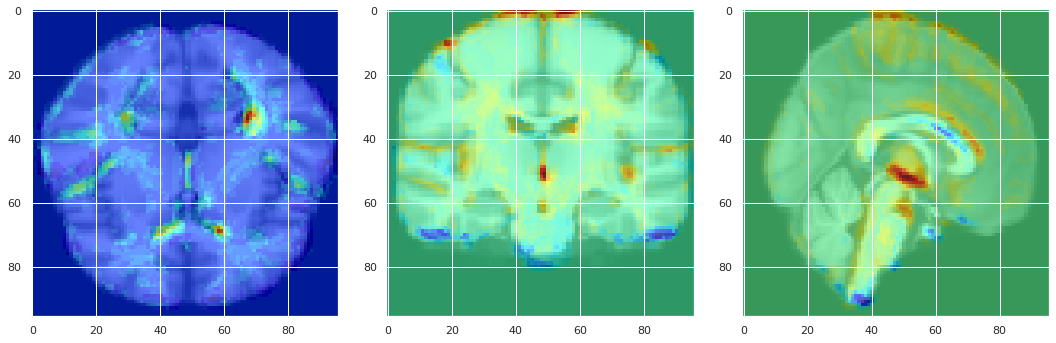

In [265]:
point = 5.656725651858605
# naive_cut = make_maeckpt_maps("naive", point)
# make_soft_thresholded_map(naive_cut, quantile);

augment_cut, num_maps = make_maeckpt_maps("augment", point)
make_soft_thresholded_map(augment_cut, quantile);

Make naive Point 9.10397546054239. Selected 100 maps. Average Epoch 3.08 | Average MAE 8.423751549916725.


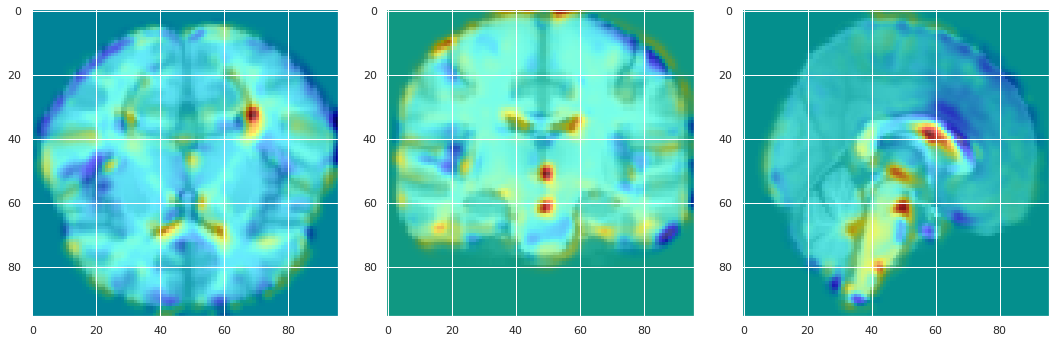

Make augment Point 9.10397546054239. Selected 100 maps. Average Epoch 4.04 | Average MAE 8.98959106602081.


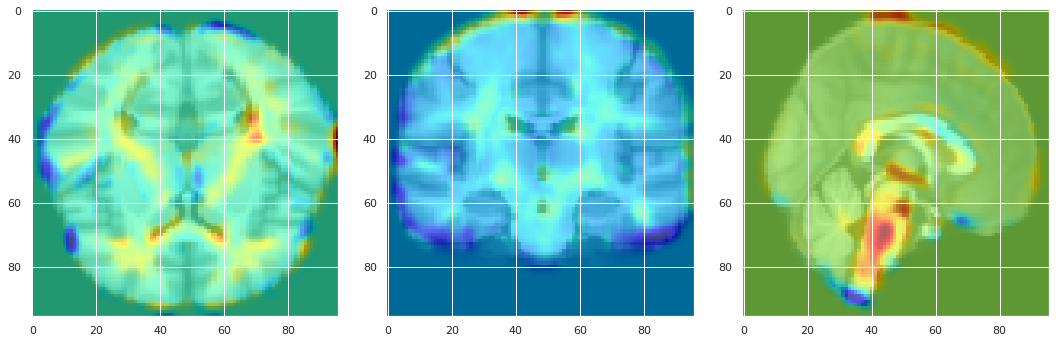

******************************
Make naive Point 8.736996829764482. Selected 100 maps. Average Epoch 3.16 | Average MAE 8.333780872397226.


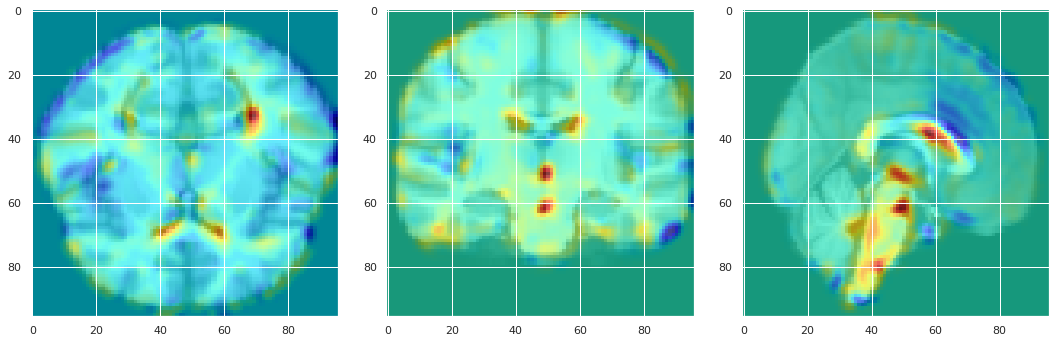

Make augment Point 8.736996829764482. Selected 100 maps. Average Epoch 4.52 | Average MAE 8.592151845252678.


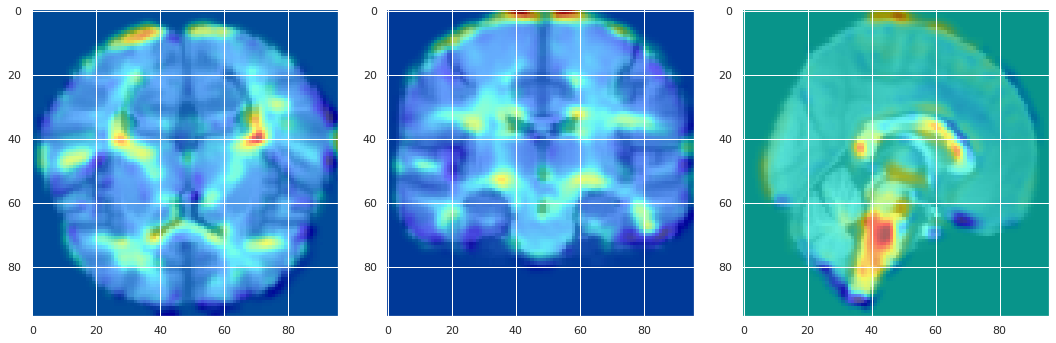

******************************
Make naive Point 8.370018198986575. Selected 100 maps. Average Epoch 3.44 | Average MAE 8.078041426384287.


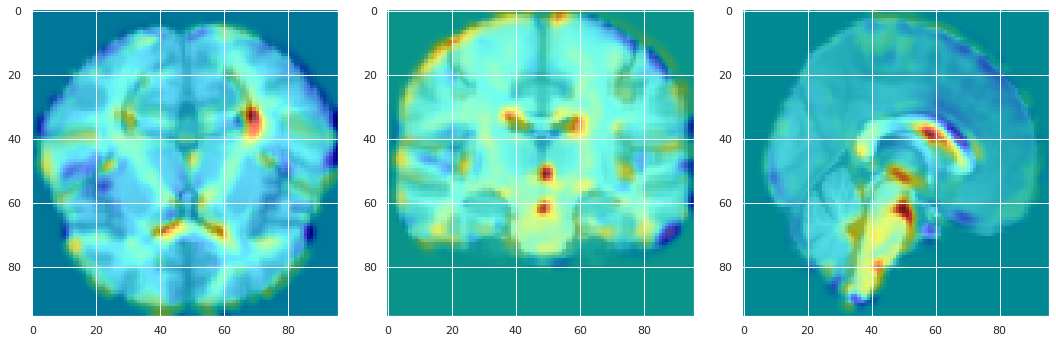

Make augment Point 8.370018198986575. Selected 100 maps. Average Epoch 5.08 | Average MAE 8.27842900302312.


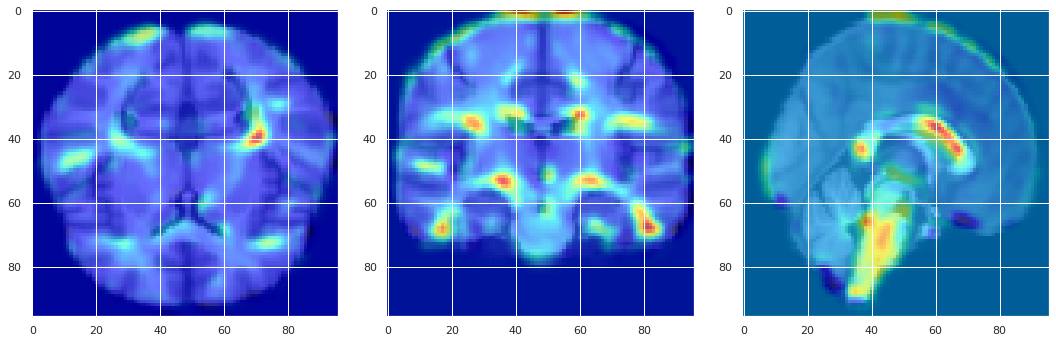

******************************
Make naive Point 8.003039568208667. Selected 100 maps. Average Epoch 3.91 | Average MAE 7.891050229072572.


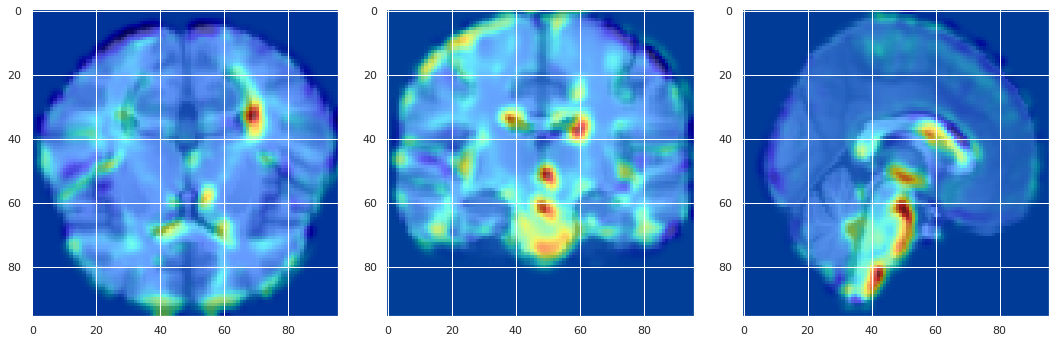

Make augment Point 8.003039568208667. Selected 100 maps. Average Epoch 6.01 | Average MAE 7.938242871924622.


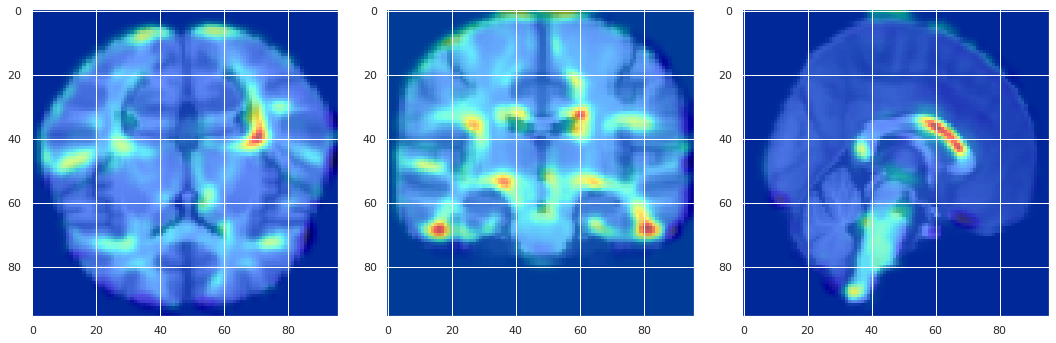

******************************
Make naive Point 7.636060937430761. Selected 100 maps. Average Epoch 4.54 | Average MAE 7.569467528225619.


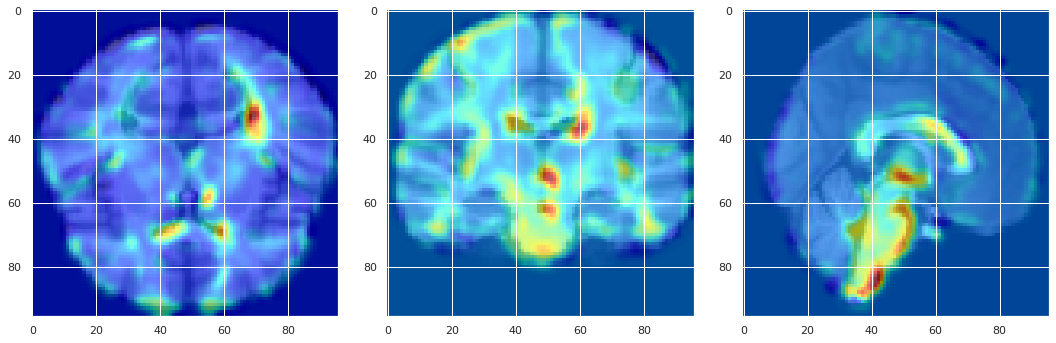

Make augment Point 7.636060937430761. Selected 100 maps. Average Epoch 7.93 | Average MAE 7.602257657769607.


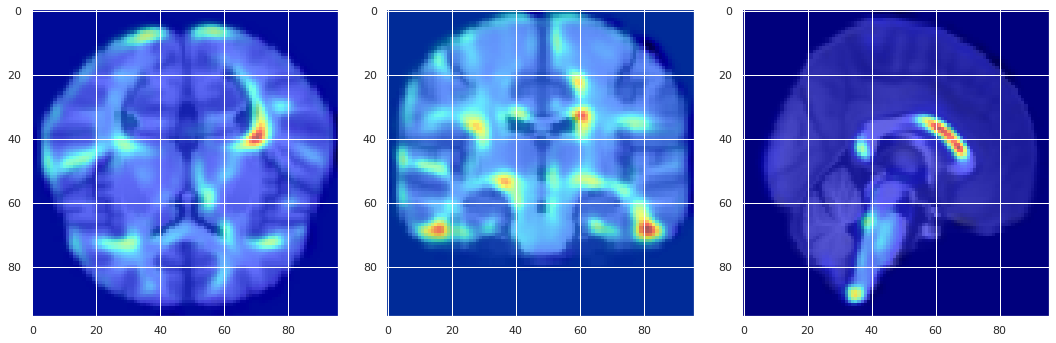

******************************
Make naive Point 7.269082306652853. Selected 100 maps. Average Epoch 6.14 | Average MAE 7.243373243122884.


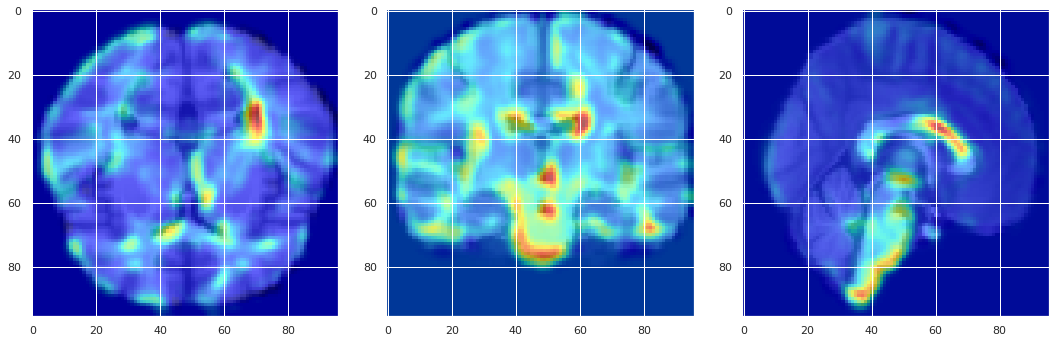

Make augment Point 7.269082306652853. Selected 100 maps. Average Epoch 10.54 | Average MAE 7.232166237373876.


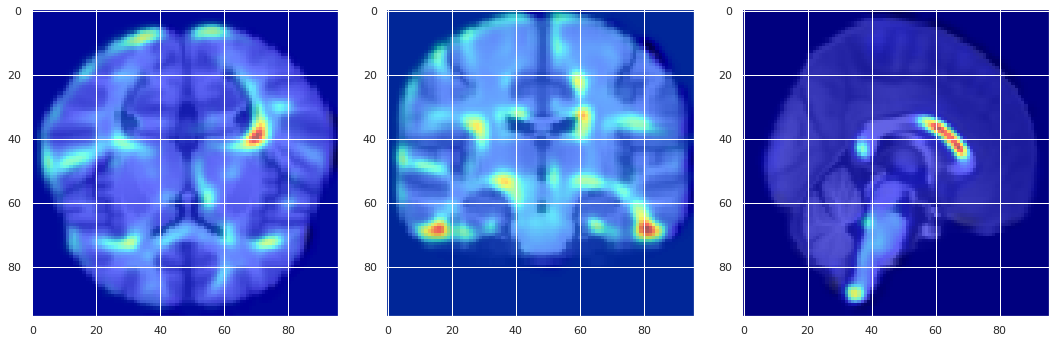

******************************
Make naive Point 6.902103675874946. Selected 100 maps. Average Epoch 9.99 | Average MAE 6.826436400217556.


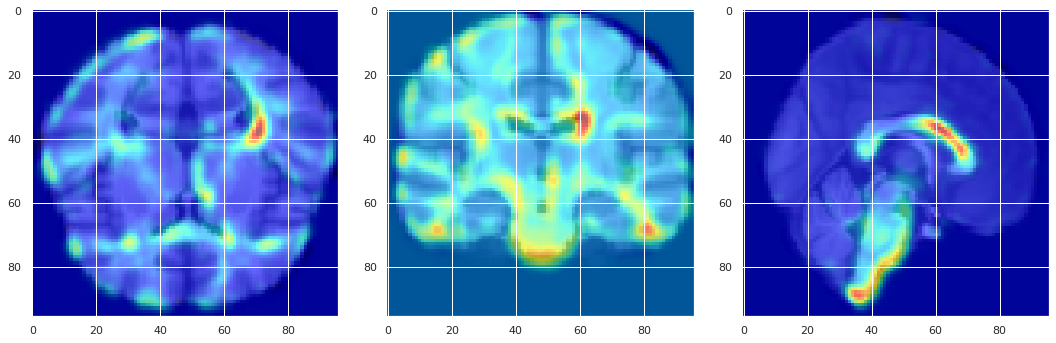

Make augment Point 6.902103675874946. Selected 100 maps. Average Epoch 15.71 | Average MAE 6.879027675994459.


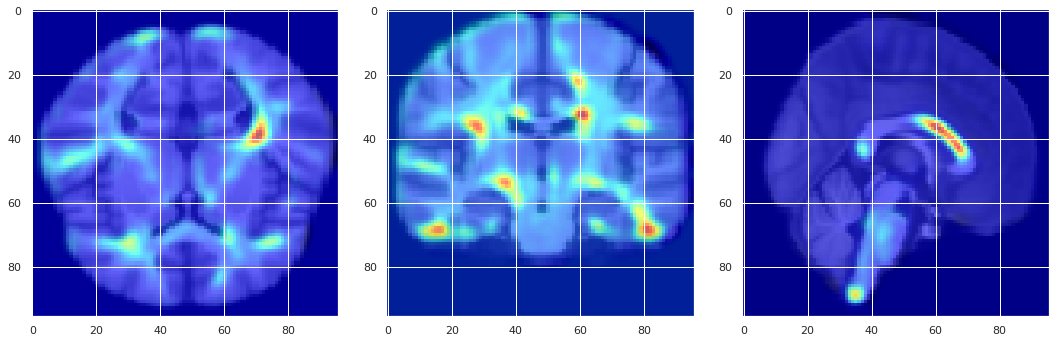

******************************
Make naive Point 6.535125045097038. Selected 92 maps. Average Epoch 17.67391304347826 | Average MAE 6.48600266418548.
13 32
24 35
27 49
43 37
56 31
58 29
67 28
71 34


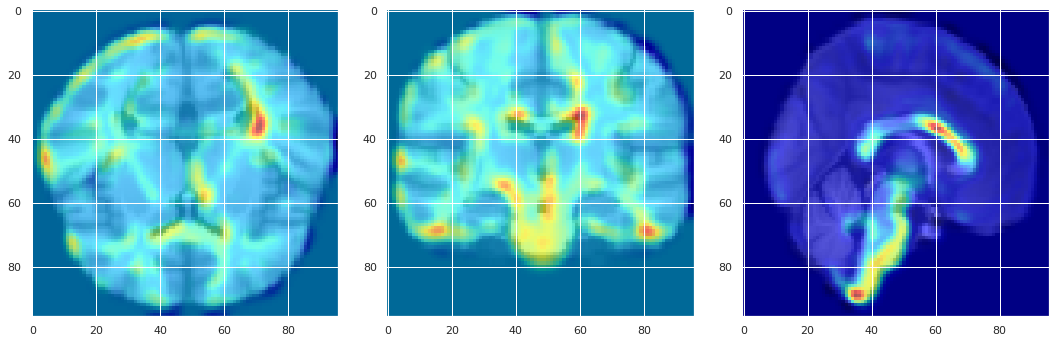

Make augment Point 6.535125045097038. Selected 100 maps. Average Epoch 22.72 | Average MAE 6.51692499696392.


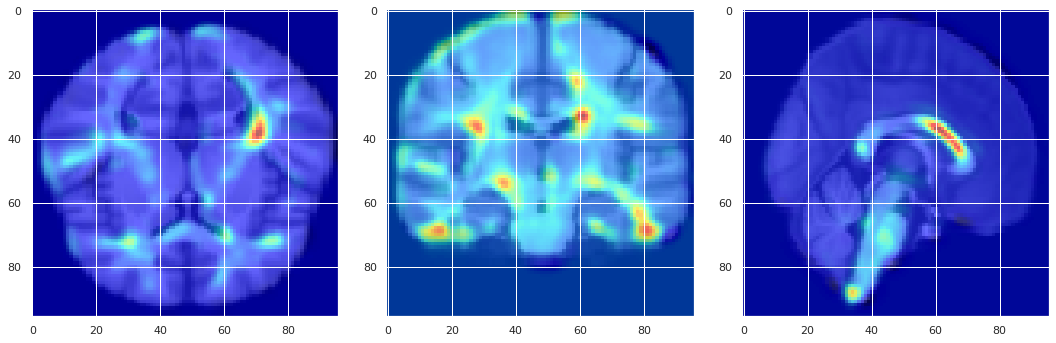

******************************
Make naive Point 6.16814641431913. Selected 70 maps. Average Epoch 27.8 | Average MAE 6.137156445079587.
5 38
11 37
13 32
20 65
23 43
24 35
25 34
26 45
27 49
30 33
31 30
40 37
43 37
44 40
46 45
51 34
56 31
58 29
60 37
65 58
67 28
68 43
71 34
80 38
82 49
90 51
91 39
93 41
95 53
97 52


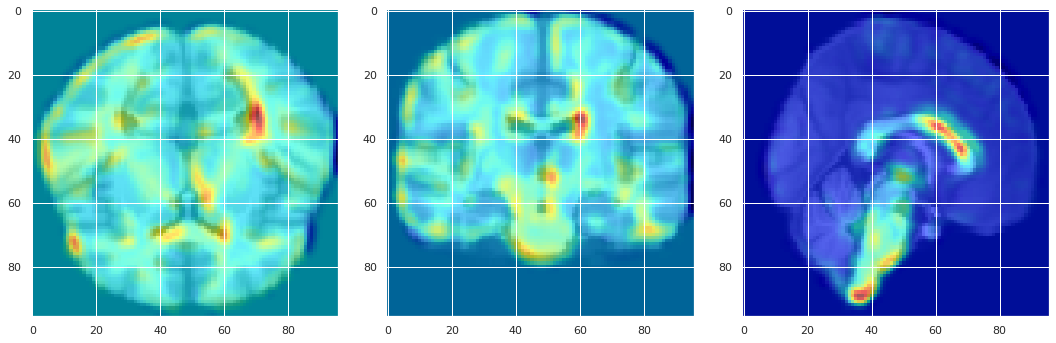

Make augment Point 6.16814641431913. Selected 92 maps. Average Epoch 31.934782608695652 | Average MAE 6.128814241018515.
17 44
20 49
29 53
41 59
44 35
72 35
89 62
96 42


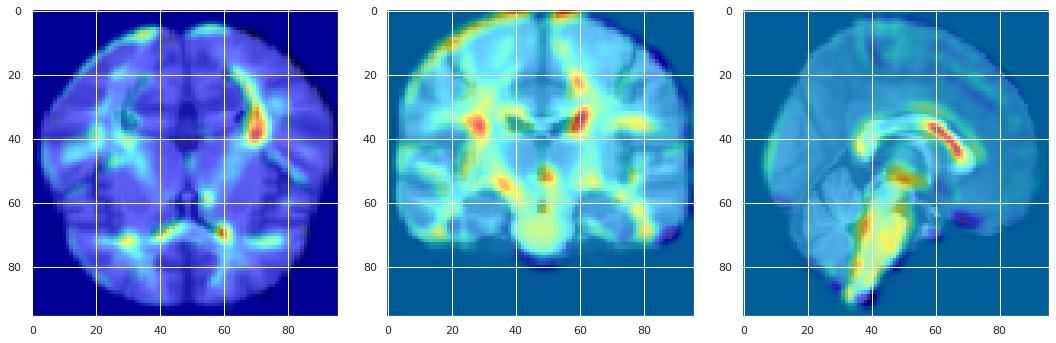

******************************
Make naive Point 5.801167783541223. Selected 40 maps. Average Epoch 43.725 | Average MAE 5.758020533274297.
0 97
3 44
5 38
6 49
8 42
10 63
11 37
13 32
14 42
17 47
19 34
20 65
23 43
24 35
25 34
26 45
27 49
29 34
30 33
31 30
40 37
41 48
42 27
43 37
44 40
46 45
47 45
50 86
51 34
54 48
55 80
56 31
58 29
60 37
62 51
65 58
66 39
67 28
68 43
69 62
70 50
71 34
75 63
77 50
78 59
79 32
80 38
81 48
82 49
87 54
89 60
90 51
91 39
92 72
93 41
94 48
95 53
96 58
97 52
99 60


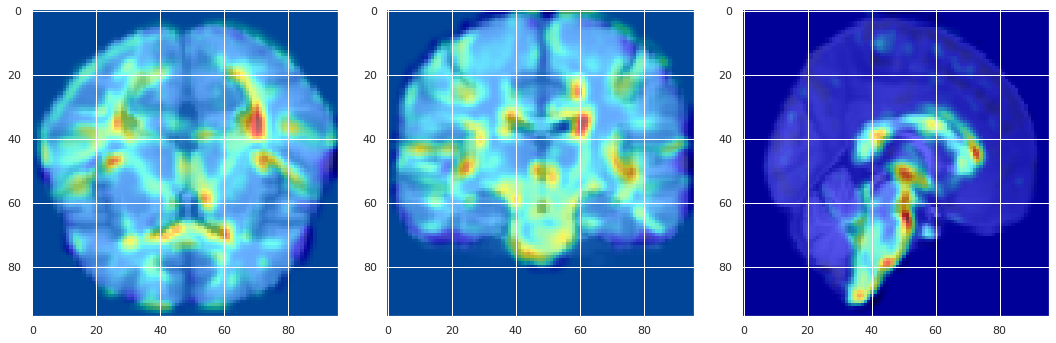

Make augment Point 5.801167783541223. Selected 67 maps. Average Epoch 43.701492537313435 | Average MAE 5.750011201334791.
0 39
4 52
5 40
10 29
12 44
14 66
17 44
18 46
19 60
20 49
24 57
27 53
29 53
30 50
36 41
41 59
44 35
47 66
53 60
55 49
56 89
59 78
61 59
66 43
67 45
70 52
71 53
72 35
80 43
81 47
84 61
89 62
96 42


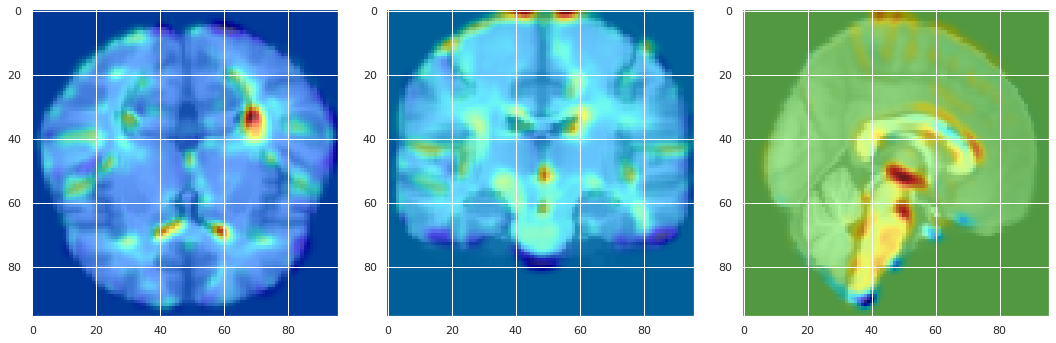

******************************


In [272]:
# for point in [53, 45, 23, 8, 7.5, 7, 6.5, 6, 5.5]:
# for point in [53, 45, 23] + [start - (start - end) * ((i+1) / 10) for i in range(10)]:
for point in [start - (start - end) * ((i+1) / 10) for i in range(10)]:

    naive_cut, num_maps = make_maeckpt_maps("naive", point)
    make_soft_thresholded_map(naive_cut, quantile);
    # exp_quantile_agree(naive_cut, .9, round(num_maps / 2));

    augment_cut, num_maps = make_maeckpt_maps("augment", point)
    make_soft_thresholded_map(augment_cut, quantile);
    # exp_quantile_agree(augment_cut, .9, round(num_maps / 2));
    print(f"{'*' *  30}")